In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import normalize, StandardScaler
from umap.umap_ import UMAP
from sklearn import metrics
import numpy as np

from kneed import KneeLocator

from statistics import mode
import os
from dotenv import load_dotenv

load_dotenv()
DB_PATH = os.getenv("DATABASE_URL", "sqlite.db")

import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class QuestionClusterer:

    def __init__(self, rei_id, period, num_clusters, embedder_model="hiiamsid/sentence_similarity_spanish_es", model=None):
        self.embedder = model if model else SentenceTransformer(embedder_model)
        self.clustering_model = None
        self.num_clusters = num_clusters if num_clusters else None
        self.questions = []
        self.dfcorpus = None
        self.rei_id = rei_id
        self.period = period
        self.embeddings = None

    @staticmethod
    def optimalK(data, nrefs=3, maxClusters=15):
        """
            Gap Statistic for K means
        """
        gaps = np.zeros((len(range(1, maxClusters)),))
        resultsdf = []

        for gap_index, k in enumerate(range(1, maxClusters)):
            # Holder for reference dispersion results
            refDisps = np.zeros(nrefs)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop

            for i in range(nrefs):
                # Create new random reference set
                randomReference = np.random.random_sample(size=data.shape)

                # Fit to it
                km = KMeans(k)
                km.fit(randomReference)

                refDisp = km.inertia_
                refDisps[i] = refDisp

                # Fit cluster to original data and create dispersion
                km = KMeans(k)
                km.fit(data)

                origDisp = km.inertia_# Calculate gap statistic
                gap = np.log(np.mean(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
                gaps[gap_index] = gap

                resultsdf.append([k,gap])

                df_extended = pd.DataFrame(resultsdf, columns=['clusterCount', 'gap'])

        return (gaps.argmax() + 1, df_extended)

    @staticmethod
    def select_optimal_k(embeddings, maxClusters=15):
        """
            Selecciona el número óptimo de clusters utilizando puntuación de Silhouette.
        """
        scores = []
        for k in range(2, maxClusters + 1):
            kmeans = KMeans(n_clusters=k).fit(embeddings)
            labels = kmeans.labels_
            score = silhouette_score(embeddings, labels, metric='cosine')
            #score = calinski_harabasz_score(embeddings, labels)
            scores.append(score)

        # Encontrar el índice del máximo score
        best_k = np.argmax(scores) + 2
        # Verificar si hay meseta
        if best_k == 2 and maxClusters > 5:
            threshold = 0.9 * max(scores)
            candidates = np.where(np.array(scores) >= threshold)[0] + 2
            if len(candidates) > 1:
                best_k = candidates[-1]
        return best_k

    @staticmethod
    def select_optimal_k_max(embeddings, max_k=15):
        """
        Selección de k óptimo usando criterios múltiples con votación ponderada.
        Considera:
        - Silhouette Score (maximizar)
        - Davies-Bouldin Score (minimizar)
        - Calinski-Harabasz Score (maximizar)
        """
        metrics = {
            'silhouette': [],
            'davies_bouldin': [],
            'calinski_harabasz': []
        }
        
        for k in range(2, max_k + 1):
            kmeans = KMeans(n_clusters=k).fit(embeddings)
            labels = kmeans.labels_
            
            # Evitar cálculo de silhouette si solo un cluster (todos los puntos iguales)
            if len(np.unique(labels)) == 1:
                metrics['silhouette'].append(-1)
            else:
                metrics['silhouette'].append(silhouette_score(embeddings, labels, metric='cosine'))
            
            metrics['davies_bouldin'].append(davies_bouldin_score(embeddings, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(embeddings, labels))
        
        # Normalizar scores
        def normalize(scores, invert=False):
            scores = np.array(scores)
            if invert:
                scores = 1 / (scores + 1e-10)
            return (scores - scores.min()) / (scores.max() - scores.min())
        
        norm_sil = normalize(metrics['silhouette'])
        norm_db = normalize(metrics['davies_bouldin'], invert=True)
        norm_ch = normalize(metrics['calinski_harabasz'])
        
        # Score combinado (promedio ponderado)
        combined_score = (norm_sil * 0.5) + (norm_db * 0.3) + (norm_ch * 0.2)
        best_k = np.argmax(combined_score) + 2  # +2 porque empezamos desde k=2
        
        # Verificación de meseta (evitar k=2 cuando hay mejor opción)
        
        if best_k == 2 and max_k > 5:
            threshold = 0.9 * combined_score.max()
            candidates = np.where(combined_score >= threshold)[0] + 2
            if len(candidates) > 1:
                best_k = candidates[-1]  # Elige el k más grande dentro del 90% del mejor score
        
        return best_k

    @staticmethod
    def select_k_thesis(embeddings, max_k=15):
        scores = []
        for k in range(2, max_k+1):
            kmeans = KMeans(n_clusters=k).fit(embeddings)
            scores.append(calinski_harabasz_score(embeddings, kmeans.labels_))
        
        # return the best k
        best_k = np.argmax(scores) + 2  # +2 porque empezamos desde k=2
        return best_k

    @staticmethod
    def select_k_thesis2(embeddings, max_k=15):
        scores = []
        for k in range(2, max_k + 1):
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(embeddings)
            scores.append(calinski_harabasz_score(embeddings, kmeans.labels_))
        
        # 2. Detección de codo con parámetros optimizados
        kl = KneeLocator(
            range(2, max_k + 1),
            scores,
            curve='concave',
            direction='increasing',
            interp_method='polynomial',
            polynomial_degree=5,
            S=1.0
        )
        
        # 3. Lógica de decisión mejorada
        if kl.elbow is not None:
            best_k = kl.elbow
            # Verificación de meseta para k=2
            if best_k == 2 and max_k > 5:
                threshold = 0.9 * max(scores)
                candidates = np.where(np.array(scores) >= threshold)[0] + 2
                if len(candidates) > 1:
                    best_k = candidates[-1]  # Selecciona el k más alto en la meseta
        else:
            # Fallback: máximo global con verificación de meseta
            logging.warning("No se detectó codo. Usando el máximo global.")
            best_k = np.argmax(scores) + 2
            threshold = 0.85 * max(scores)
            candidates = np.where(np.array(scores) >= threshold)[0] + 2
            if len(candidates) > 1:
                best_k = candidates[1]  # Evita seleccionar el máximo si hay meseta cercana
        
        return best_k

    @staticmethod
    def combined_clustering_score(X, max_k=15):
        scores = []
        
        for k in range(2, max_k + 1):
            kmeans = KMeans(n_clusters=k)
            labels = kmeans.fit_predict(X)
            
            # Calcular métricas
            silhouette = silhouette_score(X, labels, metric='cosine')
            davies_bouldin = davies_bouldin_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            
            # Normalizar métricas (Silhouette: [-1, 1], DB: [0, inf], CH: [0, inf])
            norm_silhouette = (silhouette + 1) / 2  # Escalar a [0, 1]
            norm_davies_bouldin = 1 / (1 + davies_bouldin)  # Invertir y escalar
            norm_calinski_harabasz = calinski_harabasz / (calinski_harabasz + 1)  # Escalar asintóticamente
            
            # Ponderar métricas en parte iguales
            combined = (norm_silhouette + norm_davies_bouldin + norm_calinski_harabasz) / 3
            
            scores.append((k, combined, silhouette, davies_bouldin, calinski_harabasz))
        
        # Seleccionar k con el puntaje combinado más alto
        best_k = max(scores, key=lambda x: x[1])[0]
        return best_k

    def fetch_questions(self):
        query = f"""
            SELECT question, coalesce(g.id, 'Desconocido') as group_id, coalesce(u.name, 'Desconocido') as lider_name
            FROM "dx_question" q
            LEFT JOIN "class" c ON c.id = q.class_id
            LEFT JOIN "group" g ON g.id = q.group_id
            LEFT JOIN "user" u ON u.id = g.lider_id
            WHERE c.id = ? AND c.recorrido_id = ?;
        """

        with sqlite3.connect(DB_PATH) as con:
            cursor = con.cursor()
            cursor.execute(query, (self.period, self.rei_id))
            result = cursor.fetchall()
            logging.info(f"Fetched {len(result)} questions from dx_question for REI ID: {self.rei_id} and period: {self.period}")
            self.questions = result

    def preprocess_questions(self):
        if not self.questions:
            return pd.DataFrame(columns=["pregunta", "grupo", "lider_name", "votos"])

        self.dfcorpus = pd.DataFrame(self.questions)
        self.dfcorpus = self.dfcorpus.rename(columns={0: "pregunta", 1: "grupo", 2: "lider_name"})

        self.dfcorpus["votos"] = 1
        """
        self.generate_embeddings()

        # Compute cosine similarities
        similarities = self.embedder.similarity(self.embeddings, self.embeddings)
        to_remove = []

        for idx_i, sentence1 in enumerate(self.dfcorpus['pregunta']):
            count_matches = 0
            match_groups = self.dfcorpus['grupo'].iloc[idx_i]

            for idx_j, sentence2 in enumerate(self.dfcorpus['pregunta']):
                sim = similarities[idx_i][idx_j]

                if (sim > 0.9) and (idx_i != idx_j):
                    count_matches += 1
                    gxj = self.dfcorpus['grupo'].iloc[idx_j]
                    match_groups = match_groups + "," + gxj

                    if (idx_j>idx_i):
                        to_remove.append(idx_j)

            self.dfcorpus.iloc[idx_i, self.dfcorpus.columns.get_loc('votos')] = count_matches + 1
            self.dfcorpus.iloc[idx_i, self.dfcorpus.columns.get_loc('grupo')] = str(match_groups)

        if len(to_remove)>0:
            rm_indexes = np.array(to_remove)
            self.dfcorpus = self.dfcorpus.drop(self.dfcorpus.index[rm_indexes])
            logging.info(f"Removed {len(to_remove)} duplicate questions based on cosine similarity.")
        """

    @staticmethod
    def plot_clusters(embeddings, cluster_assignment):
        reducer = UMAP(n_components=2, metric='cosine', random_state=42)
        reduced_embeds = reducer.fit_transform(embeddings)
        
        plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1], 
                    c=cluster_assignment, cmap='Spectral', s=10)
        plt.title("Clusters después de UMAP")
        plt.colorbar()
        plt.show()

    def train_cluster_model(self, corpus_embeddings):

        if not self.num_clusters:
            if len(corpus_embeddings)<15:
                maxC=len(corpus_embeddings)
            else:
                maxC=20

            scores = []
            for i in range(0,5):
                #score_g1, df = QuestionClusterer.optimalK(corpus_embeddings, maxClusters=maxC)
                #score_g2 = QuestionClusterer.select_optimal_k_max(corpus_embeddings, max_k=maxC)
                #score_g3 = QuestionClusterer.select_optimal_k(corpus_embeddings, maxClusters=maxC)
                score_g = QuestionClusterer.select_k_thesis(corpus_embeddings, max_k=maxC)
                #score_g5 = QuestionClusterer.combined_clustering_score(corpus_embeddings, max_k=maxC)
                #logging.info(f"gap statistic: {score_g1}, scd+meseta: {score_g2}, silhouette+knee+meseta: {score_g3}, ch+knee: {score_g}, scd: {score_g5}")
                scores.append(score_g)

            score_g = mode(scores)
            self.num_clusters = score_g

        self.clustering_model = KMeans(n_clusters=self.num_clusters)
        self.clustering_model.fit(corpus_embeddings)

    def generate_embeddings(self):
        corpus = self.dfcorpus["pregunta"].tolist()
        self.embeddings = self.embedder.encode(corpus, batch_size=48)
        #logging.info(f'varianza: {np.var(corpus_embeddings).min() / np.var(corpus_embeddings).max()}')
        #logging.info(f'varianza: {np.var(corpus_embeddings)}')

        # Normalización de los embeddings
        #scaler = StandardScaler()
        #self.embeddings = scaler.fit_transform(corpus_embeddings)
        #logging.info(f'varianza: {np.var(self.embeddings).min() / np.var(self.embeddings).max()}')
        #logging.info(f'varianza: {np.var(self.embeddings)}')


    def clusterize_dx_questions(self, num_clusters=None, n_components=15, n_neighbors=15, min_dist=0.1):
        if num_clusters:
            self.num_clusters = num_clusters

        reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric='cosine', repulsion_strength=1.5)
        embeddings_to_use = reducer.fit_transform(self.embeddings)
        #reducer = PCA(n_components=n_components)
        #embeddings_to_use = reducer.fit_transform(self.embeddings)
        # Aplicar normalización
        #embeddings_to_use = normalize(reduced_embeddings, norm='l2')
        #embeddings_to_use = self.embeddings

        self.train_cluster_model(embeddings_to_use)

        cluster_assignment = self.clustering_model.labels_
        cluster_assignment = [x + 1 for x in cluster_assignment]

        self.dfcorpus['cluster'] = cluster_assignment

        # Visualización
        #QuestionClusterer.plot_clusters(embeddings_to_use, self.dfcorpus['cluster'])

        # Evaluación
        if len(set(cluster_assignment)) > 1:
            silhouette = silhouette_score(embeddings_to_use, cluster_assignment, metric='cosine')
            logging.info(f"Silhouette Score: {silhouette:.3f}")
            return silhouette
        else:
            logging.warning("No se puede calcular el Silhouette Score con un único cluster.")


In [3]:
rei_id = "a40e039f-c630-4d30-a4db-e812e3106568"
period = "cdbb4989-6aa7-4663-8dcf-5cee59a6f54a"
db_path = "sqlite.db"

#embedder_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
embedder_model='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
#embedder_model="hiiamsid/sentence_similarity_spanish_es"
#embedder_model='projecte-aina/roberta-base-ca-v2'

question_clusterer = QuestionClusterer(rei_id, period, num_clusters=0, embedder_model=embedder_model)
question_clusterer.fetch_questions()
question_clusterer.preprocess_questions()
question_clusterer.generate_embeddings()

2025-05-11 04:48:04,668 - INFO - Use pytorch device_name: mps
2025-05-11 04:48:04,668 - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
2025-05-11 04:48:09,119 - INFO - Fetched 94 questions from dx_question for REI ID: a40e039f-c630-4d30-a4db-e812e3106568 and period: cdbb4989-6aa7-4663-8dcf-5cee59a6f54a
Batches: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


# Metrics functions

In [3]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def calculate_metrics(df_real, labels_pred, cols=['JB', 'LF', 'KM1', 'NR1', 'MB']):
    """
    Calculate clustering metrics for each human-labeled column in df_real.

    Parameters:
    - df_real: DataFrame containing human-labeled clusters.
    - labels_pred: Predicted cluster labels from the model.
    - cols: List of columns in df_real to compare against.

    Returns:
    - metrics_dict: Dictionary containing averaged metrics across all columns.
    """
    results = []
    for col in cols:
        labels_true = df_real[col]
        
        # Calculate metrics
        ami = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
        ari = metrics.adjusted_rand_score(labels_true, labels_pred)
        purity = purity_score(labels_true, labels_pred)  # Using the purity_score function defined earlier
        hom = metrics.homogeneity_score(labels_true, labels_pred)
        com = metrics.completeness_score(labels_true, labels_pred)
        nmi = metrics.normalized_mutual_info_score(labels_true, labels_pred)
        vm = metrics.v_measure_score(labels_true, labels_pred)
        
        results.append({
            'Ground Truth': col,
            'AMI': ami,
            'ARI': ari,
            'NMI': nmi,
            'Pureza': purity,
            'Homogeneidad': hom,
            'Completitud': com,
            'V-measure': vm
        })
    
    # Create a DataFrame from the results
    metrics_df = pd.DataFrame(results)
    
    return metrics_df

# Preprocess humans clusters

In [5]:
df_real = pd.read_excel('./ZBE-es.xlsx')
# Limpiar nombres de columnas
df_real.columns = df_real.columns.str.strip().str.replace(r"\s+", " ", regex=True)
# Eliminar espacios al principio y al final de las celdas de texto
df_real = df_real.map(lambda x: x.strip() if isinstance(x, str) else x)
df_real = df_real.dropna(axis=1, how='any')

# descartar filas que fueron eliminadas en el preprocesamiento
df = df_real.loc[question_clusterer.dfcorpus.index]


# Comparar índices de df_real y dfcorpus
if df.index.equals(question_clusterer.dfcorpus.index):
    print("Los índices de df_real y dfcorpus están alineados correctamente.")
else:
    print("Los índices de df_real y dfcorpus no están alineados.")

# Comparar preguntas
comparison = df['Question'] == question_clusterer.dfcorpus['pregunta']
if comparison.all():
    print("Todas las preguntas coinciden entre df y dfcorpus.")
else:
    print("Algunas preguntas no coinciden entre df y dfcorpus.")
    print("Preguntas diferentes:")
    print(df.loc[~comparison, ['Question']])
    print(question_clusterer.dfcorpus.loc[~comparison, ['pregunta']])

Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


# Clusterizar y evaluar

In [6]:
# Pre-allocate lists to store results instead of growing DataFrame
results = {
    'Ground Truth': [],
    'num_clusters': [],
    'n_components': [],
    'n_neighbors': [],
    'min_dist': [],
    'Silhouette': [],
    'AMI': [],
    'ARI': [],
    'NMI': [],
    'Pureza': [],
    'Homogeneidad': [],
    'Completitud': [],
    'V-measure': []
}

# Define parameter ranges
#num_clusters_range = range(2, 13)
num_clusters_range = [0]
#n_components_range = range(10, 80, 10)
n_components_range = [2,5,8,10,12,15]
#n_neighbors_range = range(5, 20, 5)
n_neighbors_range = [15]
#min_dist_range = [0.1, 0.2, 0.3, 0.4, 0.5]
min_dist_range = [0.1]

for num_clusters in num_clusters_range:
    for n_components in n_components_range:
        for n_neighbors in n_neighbors_range:
            for min_dist in min_dist_range:
                question_clusterer.num_clusters = None
                sillhouette = question_clusterer.clusterize_dx_questions(
                    num_clusters=num_clusters, 
                    n_components=n_components,
                    n_neighbors=n_neighbors,
                    min_dist=min_dist
                )
                
                # Calculate met
                met = calculate_metrics(
                    df, 
                    question_clusterer.dfcorpus['cluster'], 
                    cols=['JB', 'LF', 'KM1', 'NR1', 'MB']
                )
                
                # Append results to lists
                for idx, row in met.iterrows():
                    results['Ground Truth'].append(row['Ground Truth'])
                    results['num_clusters'].append(question_clusterer.num_clusters)
                    results['n_components'].append(n_components)
                    results['n_neighbors'].append(n_neighbors)
                    results['min_dist'].append(min_dist)
                    results['Silhouette'].append(sillhouette)
                    results['AMI'].append(row['AMI'])
                    results['ARI'].append(row['ARI'])
                    results['NMI'].append(row['NMI'])
                    results['Pureza'].append(row['Pureza'])
                    results['Homogeneidad'].append(row['Homogeneidad'])
                    results['Completitud'].append(row['Completitud'])
                    results['V-measure'].append(row['V-measure'])


                question_clusterer.clustering_model = None
                question_clusterer.dfcorpus['cluster'] = None

# Convert results to DataFrame
results_df = pd.DataFrame(results)


/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-05-11 04:48:34,289 - INFO - Silhouette Score: -0.218
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-11 04:48:34,550 - INFO - Silhouette Score: 0.523
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.1

In [7]:
results_df.sort_values(by='Silhouette', ascending=False)

,Ground Truth,num_clusters,n_components,n_neighbors,min_dist,Silhouette,AMI,ARI,NMI,Pureza,Homogeneidad,Completitud,V-measure
29,MB,11,15,15,0.1,0.689412,0.320370,0.231230,0.433786,0.606383,0.505261,0.380027,0.433786
28,NR1,11,15,15,0.1,0.689412,0.338730,0.214936,0.488222,0.563830,0.520325,0.459851,0.488222
27,KM1,11,15,15,0.1,0.689412,0.199321,0.103150,0.396487,0.489362,0.431604,0.366654,0.396487
26,LF,11,15,15,0.1,0.689412,0.207381,0.102562,0.467326,0.510638,0.478123,0.457005,0.467326
25,JB,11,15,15,0.1,0.689412,0.428291,0.284921,0.552242,0.627660,0.591129,0.518156,0.552242
24,MB,13,12,15,0.1,0.658256,0.331764,0.212002,0.458360,0.648936,0.554612,0.390576,0.458360
23,NR1,13,12,15,0.1,0.658256,0.304955,0.161813,0.479877,0.563830,0.529900,0.438484,0.479877
22,KM1,13,12,15,0.1,0.658256,0.213372,0.113608,0.425545,0.510638,0.480273,0.382013,0.425545
21,LF,13,12,15,0.1,0.658256,0.145435,0.076659,0.445524,0.510638,0.471671,0.422123,0.445524
20,JB,13,12,15,0.1,0.658256,0.406557,0.286613,0.550853,0.659574,0.611016,0.501475,0.550853


# Ponderar resultados

In [4]:
df_real = pd.read_excel('./ZBE-es.xlsx')
# Limpiar nombres de columnas
df_real.columns = df_real.columns.str.strip().str.replace(r"\s+", " ", regex=True)
# Eliminar espacios al principio y al final de las celdas de texto
df_real = df_real.map(lambda x: x.strip() if isinstance(x, str) else x)
df_real = df_real.dropna(axis=1, how='any')

def get_df(df_real, dfcorpus):
     # descartar filas que fueron eliminadas en el preprocesamiento
    df = df_real.loc[dfcorpus.index]


    # Comparar índices de df_real y dfcorpus
    if df.index.equals(dfcorpus.index):
        print("Los índices de df_real y dfcorpus están alineados correctamente.")
    else:
        print("Los índices de df_real y dfcorpus no están alineados.")

    # Comparar preguntas
    comparison = df['Question'] == dfcorpus['pregunta']
    if comparison.all():
        print("Todas las preguntas coinciden entre df y dfcorpus.")
    else:
        print("Algunas preguntas no coinciden entre df y dfcorpus.")
        print("Preguntas diferentes:")
        print(df.loc[~comparison, ['Question']])
        print(dfcorpus.loc[~comparison, ['pregunta']])

    return df

In [7]:
import torch
from torch.nn.functional import normalize
from transformers import AutoModel, AutoTokenizer

class RobertaEmbedder:
    def __init__(self, model_name='projecte-aina/roberta-base-ca-v2', dtype=torch.float32):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, torch_dtype=dtype)
        self.model.eval()
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)

    def encode(self, sentences, batch_size=32, normalize_embeddings=True):
        all_embeddings = []

        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i + batch_size]
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(self.device)

            with torch.no_grad():
                model_output = self.model(**encoded_input)

            # CLS token pooling (position 0)
            embeddings = model_output.last_hidden_state[:, 0, :]

            if normalize_embeddings:
                embeddings = normalize(embeddings, p=2, dim=1)

            all_embeddings.append(embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

In [5]:
rei_id = "a40e039f-c630-4d30-a4db-e812e3106568"
period = "cdbb4989-6aa7-4663-8dcf-5cee59a6f54a"
#period = "cdbb4989-6aa7-4663-8dcf-5cee59a6f54b"
db_path = "sqlite.db"

#embedder_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
embedder_model='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
#embedder_model='sentence-transformers/distiluse-base-multilingual-cased-v2'
#embedder_model="hiiamsid/sentence_similarity_spanish_es"
#embedder_model='projecte-aina/roberta-base-ca-v2'
#model = RobertaEmbedder()

num_clusters = 0 # Aleatorio
n_components = 10
n_neighbors = 15
min_dist = 0.1
iterations = 500

question_clusterer = QuestionClusterer(rei_id, period, num_clusters=num_clusters, embedder_model=embedder_model)
question_clusterer.fetch_questions()
question_clusterer.preprocess_questions()
question_clusterer.generate_embeddings()

#iterate 10 times and calculate average, std and min max

results_df = pd.DataFrame(columns=['Ground Truth', 'num_clusters', 'n_components', 'n_neighbors', 'Silhouette', 'min_dist', 'ARI', 'NMI', 'Pureza', 'Homogeneidad', 'Completitud', 'V-measure'])
for i in range(iterations):
    question_clusterer.num_clusters = num_clusters

    silhouette = question_clusterer.clusterize_dx_questions(
        num_clusters=num_clusters, 
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist
    )

    # Calculate metrics
    met = calculate_metrics(
        get_df(df_real, question_clusterer.dfcorpus),
        question_clusterer.dfcorpus['cluster'], 
        cols=['JB', 'KM1', 'NR1', 'MB']
    )

    #add parameters to metrics
    met['num_clusters'] = int(question_clusterer.num_clusters)
    met['n_components'] = n_components
    met['n_neighbors'] = n_neighbors
    met['min_dist'] = min_dist
    met['Silhouette'] = silhouette

    # Append results to DataFrame
    results_df = pd.concat([results_df, met], ignore_index=True)


2025-05-11 16:30:54,125 - INFO - Use pytorch device_name: mps
2025-05-11 16:30:54,125 - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
2025-05-11 16:30:58,204 - INFO - Fetched 94 questions from dx_question for REI ID: a40e039f-c630-4d30-a4db-e812e3106568 and period: cdbb4989-6aa7-4663-8dcf-5cee59a6f54a
Batches: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-05-11 16:31

Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:03,274 - INFO - Silhouette Score: 0.505
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:03,505 - INFO - Silhouette Score: 0.665
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:03,745 - INFO - Silhouette Score: 0.703
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:03,987 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:04,226 - INFO - Silhouette Score: 0.633
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:04,474 - INFO - Silhouette Score: 0.700
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:04,708 - INFO - Silhouette Score: 0.599
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:04,986 - INFO - Silhouette Score: 0.696
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:05,219 - INFO - Silhouette Score: 0.642
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:05,459 - INFO - Silhouette Score: 0.619
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:05,701 - INFO - Silhouette Score: 0.685
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:05,946 - INFO - Silhouette Score: 0.696
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:06,183 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:06,402 - INFO - Silhouette Score: 0.637
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:06,667 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:06,891 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:07,123 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:07,360 - INFO - Silhouette Score: 0.665
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:07,592 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:07,828 - INFO - Silhouette Score: 0.701
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:08,076 - INFO - Silhouette Score: 0.654
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:08,318 - INFO - Silhouette Score: 0.636
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:08,556 - INFO - Silhouette Score: 0.655
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:08,796 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:09,039 - INFO - Silhouette Score: 0.618
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:09,279 - INFO - Silhouette Score: 0.671
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:09,515 - INFO - Silhouette Score: 0.672
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:09,754 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:09,995 - INFO - Silhouette Score: 0.628
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:10,262 - INFO - Silhouette Score: 0.630
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:10,496 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:10,732 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:11,007 - INFO - Silhouette Score: 0.621
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:11,245 - INFO - Silhouette Score: 0.630
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:11,478 - INFO - Silhouette Score: 0.677
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:11,714 - INFO - Silhouette Score: 0.678
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:11,953 - INFO - Silhouette Score: 0.675
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:12,186 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:12,426 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:12,669 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:12,909 - INFO - Silhouette Score: 0.661
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:13,154 - INFO - Silhouette Score: 0.585
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:13,374 - INFO - Silhouette Score: 0.689
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:13,630 - INFO - Silhouette Score: 0.667
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:13,855 - INFO - Silhouette Score: 0.671
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:14,071 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:14,297 - INFO - Silhouette Score: 0.654
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:14,533 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:14,760 - INFO - Silhouette Score: 0.654
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:14,997 - INFO - Silhouette Score: 0.638
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:15,226 - INFO - Silhouette Score: 0.623
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:15,470 - INFO - Silhouette Score: 0.611
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:15,705 - INFO - Silhouette Score: 0.559
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:15,943 - INFO - Silhouette Score: 0.616
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:16,170 - INFO - Silhouette Score: 0.628
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:16,407 - INFO - Silhouette Score: 0.655
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:16,646 - INFO - Silhouette Score: 0.699
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:16,879 - INFO - Silhouette Score: 0.596
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:17,175 - INFO - Silhouette Score: 0.690
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:17,407 - INFO - Silhouette Score: 0.595
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:17,638 - INFO - Silhouette Score: 0.637
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:17,873 - INFO - Silhouette Score: 0.673
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:18,108 - INFO - Silhouette Score: 0.590
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:18,351 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:18,580 - INFO - Silhouette Score: 0.689
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:18,812 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:19,052 - INFO - Silhouette Score: 0.562
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:19,291 - INFO - Silhouette Score: 0.667
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:19,545 - INFO - Silhouette Score: 0.681
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:19,751 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-11 16:31:19,948 - INFO - Silhouette Score: 0.619


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.
Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-11 16:31:20,166 - INFO - Silhouette Score: 0.632
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:20,386 - INFO - Silhouette Score: 0.665
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:20,798 - INFO - Silhouette Score: 0.703
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:21,063 - INFO - Silhouette Score: 0.697
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:21,290 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:21,516 - INFO - Silhouette Score: 0.553
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:21,880 - INFO - Silhouette Score: 0.543
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:22,105 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-11 16:31:22,298 - INFO - Silhouette Score: 0.613
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.
Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:22,504 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:22,730 - INFO - Silhouette Score: 0.678
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:23,002 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:23,244 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:23,483 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:23,721 - INFO - Silhouette Score: 0.699
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:23,955 - INFO - Silhouette Score: 0.565
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:24,181 - INFO - Silhouette Score: 0.593
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:24,426 - INFO - Silhouette Score: 0.673
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:24,691 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:24,927 - INFO - Silhouette Score: 0.620
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:25,168 - INFO - Silhouette Score: 0.518
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:25,410 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:25,650 - INFO - Silhouette Score: 0.690
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:25,889 - INFO - Silhouette Score: 0.660
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:26,124 - INFO - Silhouette Score: 0.591
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:26,366 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:26,601 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:26,845 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:27,086 - INFO - Silhouette Score: 0.685
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:27,319 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:27,547 - INFO - Silhouette Score: 0.655
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:27,812 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:28,056 - INFO - Silhouette Score: 0.597
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:28,289 - INFO - Silhouette Score: 0.638
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:28,515 - INFO - Silhouette Score: 0.690
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:28,751 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:29,027 - INFO - Silhouette Score: 0.644
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:29,260 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:29,504 - INFO - Silhouette Score: 0.697
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:29,751 - INFO - Silhouette Score: 0.596
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:29,992 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:30,232 - INFO - Silhouette Score: 0.594
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:30,507 - INFO - Silhouette Score: 0.686
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:30,748 - INFO - Silhouette Score: 0.694
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:30,994 - INFO - Silhouette Score: 0.703
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:31,238 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:31,472 - INFO - Silhouette Score: 0.634
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:31,709 - INFO - Silhouette Score: 0.503
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:31,951 - INFO - Silhouette Score: 0.583
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:32,195 - INFO - Silhouette Score: 0.635
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:32,431 - INFO - Silhouette Score: 0.596
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:32,669 - INFO - Silhouette Score: 0.619
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:32,914 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:33,151 - INFO - Silhouette Score: 0.639
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:33,423 - INFO - Silhouette Score: 0.654
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:33,657 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:33,902 - INFO - Silhouette Score: 0.684
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:34,140 - INFO - Silhouette Score: 0.600
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:34,375 - INFO - Silhouette Score: 0.702
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:34,616 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:34,869 - INFO - Silhouette Score: 0.608
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:35,137 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:35,379 - INFO - Silhouette Score: 0.607
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:35,617 - INFO - Silhouette Score: 0.695
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:35,863 - INFO - Silhouette Score: 0.661
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:36,138 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:36,375 - INFO - Silhouette Score: 0.672
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:36,607 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:36,843 - INFO - Silhouette Score: 0.698
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:37,077 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:37,317 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:37,566 - INFO - Silhouette Score: 0.592
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:37,823 - INFO - Silhouette Score: 0.600
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:38,061 - INFO - Silhouette Score: 0.613
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:38,307 - INFO - Silhouette Score: 0.603
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:38,548 - INFO - Silhouette Score: 0.606
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:38,806 - INFO - Silhouette Score: 0.626
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:39,054 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:39,299 - INFO - Silhouette Score: 0.671
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:39,536 - INFO - Silhouette Score: 0.660
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:39,775 - INFO - Silhouette Score: 0.643
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:40,017 - INFO - Silhouette Score: 0.633
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:40,258 - INFO - Silhouette Score: 0.689
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:40,487 - INFO - Silhouette Score: 0.650
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:40,724 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:41,005 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:41,242 - INFO - Silhouette Score: 0.655
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:41,484 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:41,757 - INFO - Silhouette Score: 0.605
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:42,004 - INFO - Silhouette Score: 0.590
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:42,243 - INFO - Silhouette Score: 0.632
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:42,483 - INFO - Silhouette Score: 0.642
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:42,720 - INFO - Silhouette Score: 0.665
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:42,954 - INFO - Silhouette Score: 0.641
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:43,198 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:43,432 - INFO - Silhouette Score: 0.643
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:43,679 - INFO - Silhouette Score: 0.596
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:43,927 - INFO - Silhouette Score: 0.660
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:44,160 - INFO - Silhouette Score: 0.664
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:44,404 - INFO - Silhouette Score: 0.631
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:44,681 - INFO - Silhouette Score: 0.587
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:44,929 - INFO - Silhouette Score: 0.613
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:45,166 - INFO - Silhouette Score: 0.639
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:45,410 - INFO - Silhouette Score: 0.592
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:45,653 - INFO - Silhouette Score: 0.647
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:45,890 - INFO - Silhouette Score: 0.660
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:46,136 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:46,375 - INFO - Silhouette Score: 0.617
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:46,617 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:46,859 - INFO - Silhouette Score: 0.671
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:47,165 - INFO - Silhouette Score: 0.699
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:47,403 - INFO - Silhouette Score: 0.618
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:47,645 - INFO - Silhouette Score: 0.657
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:47,888 - INFO - Silhouette Score: 0.685
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:48,138 - INFO - Silhouette Score: 0.634
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:48,377 - INFO - Silhouette Score: 0.607
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:48,631 - INFO - Silhouette Score: 0.629
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:48,856 - INFO - Silhouette Score: 0.595
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:49,101 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:49,367 - INFO - Silhouette Score: 0.616
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:49,605 - INFO - Silhouette Score: 0.673
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:49,842 - INFO - Silhouette Score: 0.619
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:50,087 - INFO - Silhouette Score: 0.675
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:50,326 - INFO - Silhouette Score: 0.606
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:50,562 - INFO - Silhouette Score: 0.667
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:50,803 - INFO - Silhouette Score: 0.583
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:51,040 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:51,275 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:51,545 - INFO - Silhouette Score: 0.575
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:51,779 - INFO - Silhouette Score: 0.575
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:52,023 - INFO - Silhouette Score: 0.648
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:52,267 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:52,499 - INFO - Silhouette Score: 0.692
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:52,738 - INFO - Silhouette Score: 0.636
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:53,011 - INFO - Silhouette Score: 0.686
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:53,257 - INFO - Silhouette Score: 0.675
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:53,492 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:53,757 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:54,006 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:54,252 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:54,489 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:54,735 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:54,976 - INFO - Silhouette Score: 0.610
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:55,215 - INFO - Silhouette Score: 0.628
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:55,457 - INFO - Silhouette Score: 0.677
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:55,729 - INFO - Silhouette Score: 0.651
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:55,974 - INFO - Silhouette Score: 0.637
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:56,215 - INFO - Silhouette Score: 0.628
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:56,446 - INFO - Silhouette Score: 0.603
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:56,699 - INFO - Silhouette Score: 0.572
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:56,944 - INFO - Silhouette Score: 0.679
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:57,181 - INFO - Silhouette Score: 0.664
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:57,423 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:57,662 - INFO - Silhouette Score: 0.648
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:57,903 - INFO - Silhouette Score: 0.584
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:58,135 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:58,376 - INFO - Silhouette Score: 0.597
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:58,645 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:58,887 - INFO - Silhouette Score: 0.639
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:59,155 - INFO - Silhouette Score: 0.462
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:59,403 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:59,635 - INFO - Silhouette Score: 0.658
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:31:59,871 - INFO - Silhouette Score: 0.647
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:00,123 - INFO - Silhouette Score: 0.623
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:00,358 - INFO - Silhouette Score: 0.686
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:00,632 - INFO - Silhouette Score: 0.636
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:00,878 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:01,117 - INFO - Silhouette Score: 0.642
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:01,353 - INFO - Silhouette Score: 0.715
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:01,587 - INFO - Silhouette Score: 0.661
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:01,823 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:02,061 - INFO - Silhouette Score: 0.629
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:02,301 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:02,578 - INFO - Silhouette Score: 0.671
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:02,817 - INFO - Silhouette Score: 0.603
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:03,057 - INFO - Silhouette Score: 0.660
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:03,292 - INFO - Silhouette Score: 0.640
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:03,532 - INFO - Silhouette Score: 0.599
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:03,774 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:04,015 - INFO - Silhouette Score: 0.698
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:04,249 - INFO - Silhouette Score: 0.622
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:04,527 - INFO - Silhouette Score: 0.691
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:04,763 - INFO - Silhouette Score: 0.598
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:05,039 - INFO - Silhouette Score: 0.620
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:05,275 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:05,518 - INFO - Silhouette Score: 0.628
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:05,752 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:05,990 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:06,229 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:06,498 - INFO - Silhouette Score: 0.584
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:06,742 - INFO - Silhouette Score: 0.694
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:06,987 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:07,233 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:07,473 - INFO - Silhouette Score: 0.657
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:07,713 - INFO - Silhouette Score: 0.607
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:07,956 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:08,201 - INFO - Silhouette Score: 0.604
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:08,470 - INFO - Silhouette Score: 0.611
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:08,717 - INFO - Silhouette Score: 0.691
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:08,960 - INFO - Silhouette Score: 0.583
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:09,201 - INFO - Silhouette Score: 0.618
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:09,443 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:09,676 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:09,916 - INFO - Silhouette Score: 0.582
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:10,183 - INFO - Silhouette Score: 0.651
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:10,420 - INFO - Silhouette Score: 0.671
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:10,662 - INFO - Silhouette Score: 0.664
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:10,904 - INFO - Silhouette Score: 0.675
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:11,178 - INFO - Silhouette Score: 0.634
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:11,420 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:11,658 - INFO - Silhouette Score: 0.640
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:11,901 - INFO - Silhouette Score: 0.602
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:12,185 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:12,419 - INFO - Silhouette Score: 0.642
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:12,666 - INFO - Silhouette Score: 0.672
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:12,907 - INFO - Silhouette Score: 0.604
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:13,146 - INFO - Silhouette Score: 0.630
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:13,385 - INFO - Silhouette Score: 0.691
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:13,623 - INFO - Silhouette Score: 0.643
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:13,889 - INFO - Silhouette Score: 0.612
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:14,135 - INFO - Silhouette Score: 0.612
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:14,373 - INFO - Silhouette Score: 0.462
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:14,605 - INFO - Silhouette Score: 0.579
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:14,842 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:15,087 - INFO - Silhouette Score: 0.627
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:15,325 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:15,603 - INFO - Silhouette Score: 0.681
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:15,844 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:16,086 - INFO - Silhouette Score: 0.606
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:16,329 - INFO - Silhouette Score: 0.657
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:16,567 - INFO - Silhouette Score: 0.623
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:16,808 - INFO - Silhouette Score: 0.624
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:17,081 - INFO - Silhouette Score: 0.675
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:17,356 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:17,595 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:17,831 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:18,070 - INFO - Silhouette Score: 0.592
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:18,305 - INFO - Silhouette Score: 0.704
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:18,549 - INFO - Silhouette Score: 0.624
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:18,788 - INFO - Silhouette Score: 0.706
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:19,065 - INFO - Silhouette Score: 0.659
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:19,306 - INFO - Silhouette Score: 0.606
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:19,555 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:19,803 - INFO - Silhouette Score: 0.602
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:20,043 - INFO - Silhouette Score: 0.681
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:20,316 - INFO - Silhouette Score: 0.650
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:20,562 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:20,839 - INFO - Silhouette Score: 0.709
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:21,081 - INFO - Silhouette Score: 0.614
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:21,324 - INFO - Silhouette Score: 0.623
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:21,571 - INFO - Silhouette Score: 0.679
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:21,822 - INFO - Silhouette Score: 0.673
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:22,072 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:22,308 - INFO - Silhouette Score: 0.624
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:22,558 - INFO - Silhouette Score: 0.637
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:22,799 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:23,061 - INFO - Silhouette Score: 0.650
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:23,328 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:23,572 - INFO - Silhouette Score: 0.599
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:23,821 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:24,067 - INFO - Silhouette Score: 0.631
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:24,314 - INFO - Silhouette Score: 0.607
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:24,559 - INFO - Silhouette Score: 0.711
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:24,836 - INFO - Silhouette Score: 0.575
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:25,084 - INFO - Silhouette Score: 0.589
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:25,343 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:25,592 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:25,843 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:26,094 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:26,339 - INFO - Silhouette Score: 0.658
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:26,610 - INFO - Silhouette Score: 0.565
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:26,858 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:27,112 - INFO - Silhouette Score: 0.708
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:27,359 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:27,612 - INFO - Silhouette Score: 0.687
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:27,856 - INFO - Silhouette Score: 0.679
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:28,137 - INFO - Silhouette Score: 0.626
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:28,384 - INFO - Silhouette Score: 0.639
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:28,631 - INFO - Silhouette Score: 0.508
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:28,874 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:29,159 - INFO - Silhouette Score: 0.632
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:29,408 - INFO - Silhouette Score: 0.644
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:29,656 - INFO - Silhouette Score: 0.709
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:29,908 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:30,155 - INFO - Silhouette Score: 0.693
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:30,413 - INFO - Silhouette Score: 0.644
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:30,688 - INFO - Silhouette Score: 0.663
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:30,942 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:31,197 - INFO - Silhouette Score: 0.639
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:31,447 - INFO - Silhouette Score: 0.579
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:31,702 - INFO - Silhouette Score: 0.618
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:31,951 - INFO - Silhouette Score: 0.684
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:32,206 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:32,455 - INFO - Silhouette Score: 0.596
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:32,705 - INFO - Silhouette Score: 0.613
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:32,989 - INFO - Silhouette Score: 0.641
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:33,238 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:33,490 - INFO - Silhouette Score: 0.629
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:33,740 - INFO - Silhouette Score: 0.648
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:33,993 - INFO - Silhouette Score: 0.621
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:34,242 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:34,526 - INFO - Silhouette Score: 0.662
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:34,777 - INFO - Silhouette Score: 0.559
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:35,151 - INFO - Silhouette Score: 0.615
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:35,406 - INFO - Silhouette Score: 0.617
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:35,660 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:35,923 - INFO - Silhouette Score: 0.698
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:36,208 - INFO - Silhouette Score: 0.598
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:36,459 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:36,700 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:37,081 - INFO - Silhouette Score: 0.715
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:37,355 - INFO - Silhouette Score: 0.604
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:37,619 - INFO - Silhouette Score: 0.647
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:37,905 - INFO - Silhouette Score: 0.677
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:38,154 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:38,406 - INFO - Silhouette Score: 0.706
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:38,663 - INFO - Silhouette Score: 0.550
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:38,915 - INFO - Silhouette Score: 0.623
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:39,167 - INFO - Silhouette Score: 0.655
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:39,418 - INFO - Silhouette Score: 0.621
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:39,702 - INFO - Silhouette Score: 0.638
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:39,951 - INFO - Silhouette Score: 0.667
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:40,203 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:40,456 - INFO - Silhouette Score: 0.651
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:40,714 - INFO - Silhouette Score: 0.685
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:40,969 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:41,250 - INFO - Silhouette Score: 0.608
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:41,505 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:41,756 - INFO - Silhouette Score: 0.632
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:42,011 - INFO - Silhouette Score: 0.668
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:42,264 - INFO - Silhouette Score: 0.707
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:42,539 - INFO - Silhouette Score: 0.621
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:42,825 - INFO - Silhouette Score: 0.715
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:43,077 - INFO - Silhouette Score: 0.627
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:43,330 - INFO - Silhouette Score: 0.653
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:43,576 - INFO - Silhouette Score: 0.590
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:43,834 - INFO - Silhouette Score: 0.638
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:44,087 - INFO - Silhouette Score: 0.688
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:44,377 - INFO - Silhouette Score: 0.677
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:44,632 - INFO - Silhouette Score: 0.593
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:44,895 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:45,148 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:45,409 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:45,666 - INFO - Silhouette Score: 0.589
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:45,951 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:46,209 - INFO - Silhouette Score: 0.657
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:46,495 - INFO - Silhouette Score: 0.646
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:46,753 - INFO - Silhouette Score: 0.669
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:47,008 - INFO - Silhouette Score: 0.657
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:47,262 - INFO - Silhouette Score: 0.680
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:47,547 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:47,802 - INFO - Silhouette Score: 0.634
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:48,061 - INFO - Silhouette Score: 0.603
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:48,324 - INFO - Silhouette Score: 0.714
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:48,578 - INFO - Silhouette Score: 0.629
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:48,835 - INFO - Silhouette Score: 0.611
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:49,123 - INFO - Silhouette Score: 0.584
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:49,386 - INFO - Silhouette Score: 0.678
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:49,640 - INFO - Silhouette Score: 0.625
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:49,898 - INFO - Silhouette Score: 0.624
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:50,159 - INFO - Silhouette Score: 0.695
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:50,440 - INFO - Silhouette Score: 0.699
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:50,702 - INFO - Silhouette Score: 0.616
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:50,956 - INFO - Silhouette Score: 0.678
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:51,211 - INFO - Silhouette Score: 0.596
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:51,469 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:51,726 - INFO - Silhouette Score: 0.710
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:52,014 - INFO - Silhouette Score: 0.656
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:52,293 - INFO - Silhouette Score: 0.647
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:52,551 - INFO - Silhouette Score: 0.651
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:52,807 - INFO - Silhouette Score: 0.693
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:53,071 - INFO - Silhouette Score: 0.667
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:53,328 - INFO - Silhouette Score: 0.634
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:53,615 - INFO - Silhouette Score: 0.593
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:53,874 - INFO - Silhouette Score: 0.661
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:54,128 - INFO - Silhouette Score: 0.660
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:54,388 - INFO - Silhouette Score: 0.586
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:54,650 - INFO - Silhouette Score: 0.669
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:54,906 - INFO - Silhouette Score: 0.681
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:55,194 - INFO - Silhouette Score: 0.700
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:55,455 - INFO - Silhouette Score: 0.577
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:55,719 - INFO - Silhouette Score: 0.516
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:55,979 - INFO - Silhouette Score: 0.686
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:56,235 - INFO - Silhouette Score: 0.695
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:56,493 - INFO - Silhouette Score: 0.698
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:56,784 - INFO - Silhouette Score: 0.622
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:57,045 - INFO - Silhouette Score: 0.683
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:57,314 - INFO - Silhouette Score: 0.574
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:57,571 - INFO - Silhouette Score: 0.626
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:57,834 - INFO - Silhouette Score: 0.681
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:58,097 - INFO - Silhouette Score: 0.637
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:58,415 - INFO - Silhouette Score: 0.616
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:58,673 - INFO - Silhouette Score: 0.686
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:58,932 - INFO - Silhouette Score: 0.649
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:59,199 - INFO - Silhouette Score: 0.639
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:59,459 - INFO - Silhouette Score: 0.708
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:32:59,750 - INFO - Silhouette Score: 0.652
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:00,006 - INFO - Silhouette Score: 0.663
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:00,267 - INFO - Silhouette Score: 0.661
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:00,523 - INFO - Silhouette Score: 0.678
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:00,785 - INFO - Silhouette Score: 0.666
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:01,083 - INFO - Silhouette Score: 0.607
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:01,348 - INFO - Silhouette Score: 0.693
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:01,606 - INFO - Silhouette Score: 0.605
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:01,861 - INFO - Silhouette Score: 0.645
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:02,118 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:02,400 - INFO - Silhouette Score: 0.642
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:02,678 - INFO - Silhouette Score: 0.679
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:02,936 - INFO - Silhouette Score: 0.713
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:03,187 - INFO - Silhouette Score: 0.626
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:03,450 - INFO - Silhouette Score: 0.592
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:03,725 - INFO - Silhouette Score: 0.636
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:04,032 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:04,336 - INFO - Silhouette Score: 0.717
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:04,606 - INFO - Silhouette Score: 0.705
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:04,866 - INFO - Silhouette Score: 0.638
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:05,122 - INFO - Silhouette Score: 0.558
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:05,435 - INFO - Silhouette Score: 0.655
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:05,699 - INFO - Silhouette Score: 0.674
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:05,956 - INFO - Silhouette Score: 0.670
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:06,213 - INFO - Silhouette Score: 0.626
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:06,472 - INFO - Silhouette Score: 0.667
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:06,767 - INFO - Silhouette Score: 0.630
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:07,029 - INFO - Silhouette Score: 0.665
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:07,293 - INFO - Silhouette Score: 0.672
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:07,551 - INFO - Silhouette Score: 0.673
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:07,812 - INFO - Silhouette Score: 0.676
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


2025-05-11 16:33:08,100 - INFO - Silhouette Score: 0.619


Los índices de df_real y dfcorpus están alineados correctamente.
Todas las preguntas coinciden entre df y dfcorpus.


In [39]:
pivot = results_df.groupby('Ground Truth').agg(
    {
        'num_clusters': ['mean', 'std', 'min', 'max'],
        'Silhouette': ['mean', 'std', 'min', 'max'],
        'AMI': ['mean', 'std', 'min', 'max'],
        'ARI': ['mean', 'std', 'min', 'max'],
        'NMI': ['mean', 'std', 'min', 'max'],
        'Pureza': ['mean', 'std', 'min', 'max'],
        'Homogeneidad': ['mean', 'std', 'min', 'max'],
        'Completitud': ['mean', 'std', 'min', 'max'],
        'V-measure': ['mean', 'std', 'min', 'max']
    }
)

In [40]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pivot

num_clusters              Silhouette                      \
                     mean  std min max       mean       std       min   
Ground Truth                                                            
JB                   12.0  0.0  12  12   0.511834  0.037724  0.405006   
KM1                  12.0  0.0  12  12   0.511834  0.037724  0.405006   
MB                   12.0  0.0  12  12   0.511834  0.037724  0.405006   
NR1                  12.0  0.0  12  12   0.511834  0.037724  0.405006   

                             AMI                                     ARI  \
                   max      mean       std       min       max      mean   
Ground Truth                                                               
JB            0.597206  0.356196  0.022775  0.294963  0.415589  0.238389   
KM1           0.597206  0.187420  0.018357  0.139338  0.226983  0.100366   
MB            0.597206  0.256934  0.029898  0.185761  0.340405  0.161427   
NR1           0.597206  0.256164  0.027769  0.188957  0.338545  0.157242   

                                                 NMI                      \
                   std       min       max      mean       std       min   
Ground Truth                                                               
JB            0.022835  0.192399  0.290505  0.504495  0.017538  0.456571   
KM1           0.012982  0.058045  0.126380  0.397209  0.013844  0.360536   
MB            0.022399  0.101897  0.220894  0.389678  0.024612  0.330701   
NR1           0.022831  0.111157  0.222000  0.434123  0.021178  0.383368   

                          Pureza                               Homogeneidad  \
                   max      mean       std       min       max         mean   
Ground Truth                                                                  
JB            0.550590  0.615000  0.020716  0.574468  0.680851     0.549312   
KM1           0.426978  0.539787  0.015016  0.500000  0.574468     0.439952   
MB            0.458091  0.592021  0.023198  0.542553  0.648936     0.462247   
NR1           0.496381  0.525106  0.025550  0.468085  0.595745     0.470599   

                                           Completitud                      \
                   std       min       max        mean       std       min   
Ground Truth                                                                 
JB            0.019271  0.494085  0.600598    0.466454  0.016294  0.424352   
KM1           0.015832  0.397608  0.473924    0.362047  0.012425  0.329787   
MB            0.029226  0.390080  0.541725    0.336812  0.021336  0.287012   
NR1           0.023057  0.416112  0.536540    0.402907  0.019716  0.355402   

                       V-measure                                
                   max      mean       std       min       max  
Ground Truth                                                    
JB            0.508269  0.504495  0.017538  0.456571  0.550590  
KM1           0.388962  0.397209  0.013844  0.360536  0.426978  
MB            0.396827  0.389678  0.024612  0.330701  0.458091  
NR1           0.461814  0.434123  0.021178  0.383368  0.496381

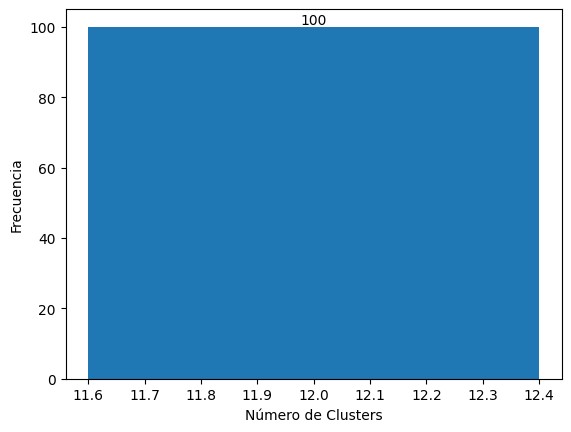

In [41]:
value_counts = results_df[results_df['Ground Truth'] == 'JB']['num_clusters'].value_counts()
plt.bar(value_counts.index, value_counts.values)
for i in range(len(value_counts)):
    plt.text(value_counts.index[i], value_counts.values[i], str(value_counts.values[i]), ha='center', va='bottom')
plt.xlabel('Número de Clusters')
plt.ylabel('Frecuencia')
plt.show()

In [42]:
# Save the results to an Excel file
output_file = f'./results/results_ca_{embedder_model.split("/")[-1]}.xlsx'
pivot.to_excel(output_file, sheet_name='Resultados', index=True)
logging.info(f"Results saved to {output_file}")

2025-05-11 16:06:35,205 - INFO - Results saved to ./results/results_ca_roberta-base-ca-v2.xlsx


# Merge files in excel

In [7]:
models = {
    'es':[
        'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', 
        'sentence-transformers/paraphrase-multilingual-mpnet-base-v2', 
        'hiiamsid/sentence_similarity_spanish_es', 
    ],
    'ca': [
        'projecte-aina/roberta-base-ca-v2', 
        'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', 
        'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
    ]
}

output_files = [f"./results/results_{lang}_{model.split('/')[-1]}.xlsx" for lang, model_list in models.items() for model in model_list]
output_files

['./results/results_es_paraphrase-multilingual-MiniLM-L12-v2.xlsx',
 './results/results_es_paraphrase-multilingual-mpnet-base-v2.xlsx',
 './results/results_es_sentence_similarity_spanish_es.xlsx',
 './results/results_ca_roberta-base-ca-v2.xlsx',
 './results/results_ca_paraphrase-multilingual-MiniLM-L12-v2.xlsx',
 './results/results_ca_paraphrase-multilingual-mpnet-base-v2.xlsx']

In [47]:
# Load all results into a single DataFrame
all_results = {}
for file in output_files:
    df = pd.read_excel(file, sheet_name='Resultados', header=[0, 1], index_col=0)
    model_name = file.split('/')[-1].split('.')[0]
    lang = file.split('_')[1]
    simplified_model_name = model_name.split('_')[2:]
    all_results[f"{lang}_{'_'.join(simplified_model_name)[-28:]}"] = df

In [36]:
all_results.keys()

dict_keys(['es_e-multilingual-MiniLM-L12-v2', 'es_e-multilingual-mpnet-base-v2', 'es_ntence_similarity_spanish_es', 'ca_roberta-base-ca-v2', 'ca_e-multilingual-MiniLM-L12-v2', 'ca_e-multilingual-mpnet-base-v2'])

In [23]:
all_results['ca_roberta-base-ca-v2'].iloc[:1]

num_clusters             Silhouette                      \
                     mean std min max       mean       std       min   
Ground Truth                                                           
JB                     12   0  12  12   0.511834  0.037724  0.405006   

                             AMI            ... Homogeneidad            \
                   max      mean       std  ...          min       max   
Ground Truth                                ...                          
JB            0.597206  0.356196  0.022775  ...     0.494085  0.600598   

             Completitud                               V-measure            \
                    mean       std       min       max      mean       std   
Ground Truth                                                                 
JB              0.466454  0.016294  0.424352  0.508269  0.504495  0.017538   

                                 
                   min      max  
Ground Truth                     
JB            0.456571  0.55059  

[1 rows x 36 columns]

In [46]:
# save each result in a separate sheet
with pd.ExcelWriter('./results/all_results.xlsx') as writer:
    for model_name, df in all_results.items():
        df.to_excel(writer, sheet_name=model_name, index=True)

In [24]:
df = all_results['ca_roberta-base-ca-v2'].iloc[:1]
df.reset_index(inplace=True)
#df.drop(columns=['Ground Truth'], inplace=True)
df

Ground Truth num_clusters             Silhouette                      \
                       mean std min max       mean       std       min   
0           JB           12   0  12  12   0.511834  0.037724  0.405006   

                  AMI  ... Homogeneidad           Completitud            \
        max      mean  ...          min       max        mean       std   
0  0.597206  0.356196  ...     0.494085  0.600598    0.466454  0.016294   

                      V-measure                               
        min       max      mean       std       min      max  
0  0.424352  0.508269  0.504495  0.017538  0.456571  0.55059  

[1 rows x 37 columns]

In [52]:
# Select the first row and reshape the DataFrame
row_data = df.iloc[0].unstack(level=1)
row_data = row_data.loc[['num_clusters', 'Silhouette', 'AMI', 'NMI', 'Pureza', 'V-measure']]
row_data = np.round(row_data, 4)

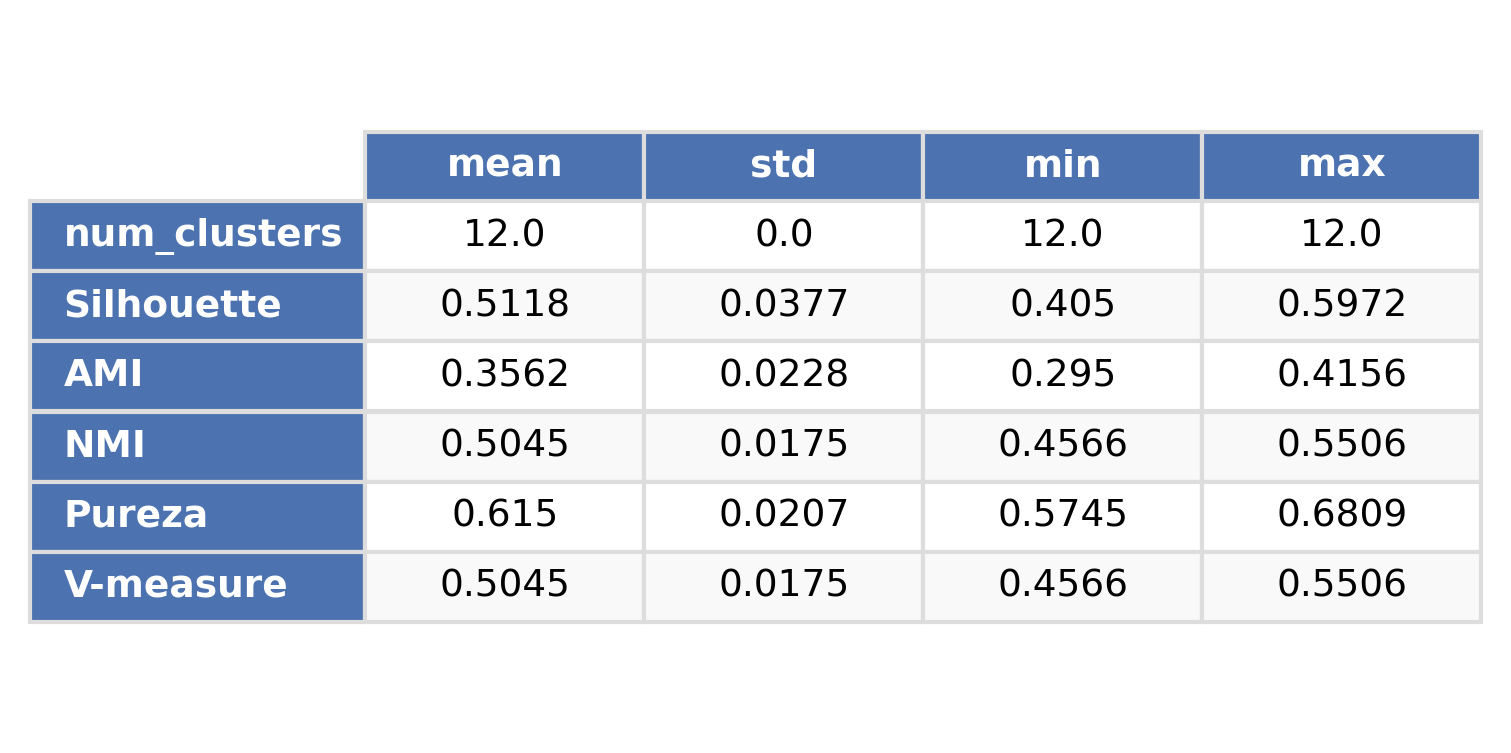

In [53]:
plt.figure(figsize=(4,3), dpi=300)
table = plt.table(
    cellText=row_data.values,
    rowLabels=row_data.index,
    colLabels=row_data.columns,
    cellLoc='center',
    loc='center'
)

# 3. Estilo profesional
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.4)  # Ajuste de tamaño

for (i, j), cell in table.get_celld().items():
    if i == 0 or j == -1:  # Encabezados
        cell.set_facecolor('#4C72B0')  # Azul profesional
        cell.set_text_props(weight='bold', color='white')
    else:  # Celdas de datos
        cell.set_facecolor('#f9f9f9' if i%2==0 else 'white')  # Filas alternas
    cell.set_edgecolor('#dddddd')

# 4. Ocultar ejes y bordes
plt.axis('off')
plt.grid(False)

#plt.title('Resultados de Clustering para MPNET', fontsize=12, weight='bold')

#plt.tight_layout()
plt.savefig('table_ca_roberta-base-ca-v2', bbox_inches='tight', dpi=300)
plt.show()

In [39]:
all_results['es_e-multilingual-MiniLM-L12-v2']

num_clusters                  Silhouette                      \
                     mean      std min max       mean       std       min   
Ground Truth                                                                
JB                  11.29  1.19168   8  15   0.654014  0.045911  0.521183   
KM1                 11.29  1.19168   8  15   0.654014  0.045911  0.521183   
MB                  11.29  1.19168   8  15   0.654014  0.045911  0.521183   
NR1                 11.29  1.19168   8  15   0.654014  0.045911  0.521183   

                             AMI            ... Homogeneidad            \
                   max      mean       std  ...          min       max   
Ground Truth                                ...                          
JB            0.773272  0.423502  0.018159  ...     0.518766  0.679072   
KM1           0.773272  0.135816  0.014998  ...     0.309482  0.466417   
MB            0.773272  0.333922  0.015410  ...     0.426948  0.586709   
NR1           0.773272  0.282590  0.016638  ...     0.386251  0.568449   

             Completitud                               V-measure            \
                    mean       std       min       max      mean       std   
Ground Truth                                                                 
JB              0.515666  0.014073  0.487973  0.558911  0.550371  0.014910   
KM1             0.323862  0.011277  0.292490  0.355004  0.350880  0.016533   
MB              0.391051  0.011085  0.361547  0.420152  0.447040  0.015483   
NR1             0.420101  0.012416  0.392486  0.442463  0.446893  0.019514   

                                  
                   min       max  
Ground Truth                      
JB            0.510971  0.591469  
KM1           0.307872  0.399078  
MB            0.391535  0.482252  
NR1           0.394326  0.497412  

[4 rows x 36 columns]

In [51]:
# continuamos con all_results. a cada pivot convertirlo en 3 dataframes [[num_clusters, Silhouette, AMI], [ARI, NMI, Pureza], [Homogeneidad, Completitud, V-measure]]
# y exportamos a excel
# Convertir cada pivot en 3 dataframes
def convert_pivot_to_dfs(pivot):
    # Convertir el índice a una columna
    #pivot_reset = pivot.reset_index(drop=True)
    pivot_reset = pivot.dropna(how='all')
    df1 = pivot_reset[['num_clusters', 'Silhouette', 'AMI']]
    df2 = pivot_reset[['ARI', 'NMI', 'Pureza']]
    df3 = pivot_reset[['Homogeneidad', 'Completitud', 'V-measure']]
    return df1, df2, df3
# Convertir y guardar cada dataframe en un solo archivo Excel. 3 hojas por modelo
def save_dfs_to_excel(pivot_dict, output_file):
    with pd.ExcelWriter(output_file) as writer:
        for model_name, pivot in pivot_dict.items():
            df1, df2, df3 = convert_pivot_to_dfs(pivot)
            df1.to_excel(writer, sheet_name=f'{model_name}_1', index=True)
            df2.to_excel(writer, sheet_name=f'{model_name}_2', index=True)
            df3.to_excel(writer, sheet_name=f'{model_name}_3', index=True)
# Guardar los pivotes en un archivo Excel
output_file = './results/pivots.xlsx'
save_dfs_to_excel(all_results, output_file)
logging.info(f"Pivot results saved to {output_file}")

/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/Users/thesportydar/local_dev/reis